In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import astropy.units as u
from astropy.stats import mad_std
import lightkurve as lk
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from datetime import date

today=date.today()
DATE =today.strftime("%m_%d_%y")

import warnings
warnings.filterwarnings("ignore")


/opt/miniconda3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/maryumsayeed/.lightkurve/cache. Please move all the files in the legacy directory /Users/maryumsayeed/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
from pyasassn.client import SkyPatrolClient

In [55]:
rv_df  = pd.read_csv('rv_df.csv')
table4 = pd.read_csv('table4.csv')
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
crossmatch_tess_all = pd.read_csv('../files/crossmatch_tess_all_binaries.csv')#[['GAIA','TIC','WISEA','2MASS','ra_dr2','dec_dr2','RAJ2000','DEJ2000']]
merged = pd.merge(crossmatch_tess_all, rv_df, on='sobject_id')#[crossmatch_tess_all.program==113]


In [5]:
# galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [6]:
binary_list_113 = [9, 11, 16, 18, 19, 23,] # old: 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = [6, 7, 23] #old: 5, 6, 7, 23 #13 removed because of dipper star

In [7]:
tic_ids_113 = {
        2: None,
        3: None,
        6: None,
        8: 128796449,
        10: 118700525,
        12: None,
        13: None,
        14: 381464967,
        15: 287332208,
        17: None,
        20: 360932244,
        22: None,
        24: 405130260,
        25: None}

tic_ids_112 = {1 : None,
        2 : 260502493,
        4 : 207251801,
        5 : 34732287 ,
        6 : 165063707,
        7 : 38023437 ,
        14 : None,
        23 : 397526519  }
    
new_df = {'program':[],'RG_id': [], 'sobject_id': [], 'TIC': []}

for i, row in rv_df.iterrows():
    sid     = row['sobject_id']
    RG_id   = row['RG_id']
    program = row['program']
    TIC     = merged[(merged.RG_id==RG_id) & (merged.program==program)]['TIC'].values
    if RG_id==23: print(TIC)
    if len(TIC) == 1: 
        TIC = TIC[0]
    elif len(TIC) == 0 and program == 112:
        TIC = tic_ids_112[RG_id]
    elif len(TIC) == 0 and program == 113:
        TIC = tic_ids_113[RG_id]
    
    new_df['program'].append(program)
    new_df['RG_id'].append(RG_id)
    new_df['sobject_id'].append(sid)
    new_df['TIC'].append(TIC)

tess_galah_ids = pd.DataFrame(new_df)


[397526519]
[129040309]


In [63]:
tess_galah_ids[tess_galah_ids.TIC==412764815]
rv_df.keys()
rv_df[rv_df.sobject_id==160327006601149].vbroad

28    25.94
Name: vbroad, dtype: float64

In [9]:
def check_tess(df):
    save_sr = {}
    for i, row in df.iterrows():
        tic = row['TIC']
        sid = row['sobject_id']
        if np.isnan(tic) == False:
            tic=int(tic)
            sr_spoc = lk.search_lightcurve('TIC %s' % tic, mission='TESS',author='TESS-SPOC')
            sr_qlp  = lk.search_lightcurve('TIC %s' % tic, mission='TESS',author='QLP')
            save_sr[int(sid)] = [sr_spoc, sr_qlp]
    return save_sr
save_sr = check_tess(tess_galah_ids)

No data found for target "TIC 207251801".
No data found for target "TIC 34732287".
No data found for target "TIC 165063707".
No data found for target "TIC 38023437".
No data found for target "TIC 306791669".
No data found for target "TIC 167669457".
No data found for target "TIC 83864042".
No data found for target "TIC 369985256".
No data found for target "TIC 128796449".
No data found for target "TIC 205846638".
No data found for target "TIC 118700525".
No data found for target "TIC 78326923".
No data found for target "TIC 287332208".
No data found for target "TIC 405924915".
No data found for target "TIC 361334013".
No data found for target "TIC 360932244".
No data found for target "TIC 412764815".
No data found for target "TIC 129040309".
No data found for target "TIC 405130260".


In [10]:
qlp_count  = 0
spoc_count = 0

for k, v in save_sr.items():
    if len(v[0]) > 0: spoc_count+=1
    if len(v[1]) > 0: qlp_count+=1
qlp_count, spoc_count

(23, 4)

In [11]:
print('total targets in our sample:',len(rv_df))
print('\t of these, also in TESS Input Catalog',tess_galah_ids['TIC'].count())
print('\t of these, QLP data available in lightkurve:',qlp_count)
print('\t of these, SPOC data available in lightkurve:',spoc_count)


total targets in our sample: 33
	 of these, also in TESS Input Catalog 23
	 of these, QLP data available in lightkurve: 23
	 of these, SPOC data available in lightkurve: 4


In [12]:
def download_lk_data():
    lk_data = {}
    for k, v in save_sr.items():
        spoc_data, qlp_data = v[0], v[1]
        print(k, len(spoc_data), len(qlp_data))
        qlp_lcs_0 = qlp_data.download_all()
        qlp_lcs   = []
        for lc in qlp_lcs_0:
            lc = lc.remove_nans().remove_outliers().normalize()
            qlp_lcs.append(lc)
        if len(spoc_data) > 0:
            spoc_lcs_0 = spoc_data.download_all()
            spoc_lcs   = []
            for lc in spoc_lcs_0:
                lc = lc.remove_nans().remove_outliers().normalize()
                spoc_lcs.append(lc)
        else:
            spoc_lcs = None
        lk_data[k] = [spoc_lcs, qlp_lcs]
    return lk_data

lk_data = download_lk_data()

151230003202196 9 43
161013005401317 0 3
161104004801189 0 3
150829004301285 0 4
160129003601260 0 3
170514002101318 2 4
140806001701013 0 5
170602003701360 0 3
170416004301008 0 2
160521004801082 0 3
170517004501165 0 4
140707003101315 0 2
161013001601153 0 1
170509005201208 0 1
150829002601352 1 4
150428000601308 0 1
170418005701333 0 3
170801002501304 2 4
170615003401088 0 5
170615003401137 0 5
160327006601149 0 3
160524006101130 0 4
170911001801179 0 3


In [36]:
c=0
c1=[]
nonbin_galah_ids=[]
for i, row in tess_galah_ids.iterrows():
    if int(row['program']) == 112 and int(row['RG_id']) in binary_list_112:
        continue
    elif int(row['program']) == 113 and int(row['RG_id']) in binary_list_113:
        continue
    else:
        nonbin_galah_ids.append(int(row['sobject_id']))
        c+=1
        if np.isnan(row['TIC']) == False:
            c1.append(row['TIC'])
            

print('total:',len(tess_galah_ids))
print('total non-binaries:',c)
print('total non-binaries in TESS:',len(c1))

nonbin_gaia_ids = rv_df[rv_df.sobject_id.isin(nonbin_galah_ids)].dr3_source_id.tolist()

total: 33
total non-binaries: 24
total non-binaries in TESS: 14


In [56]:
def plot_lk_data():
    for k, v in lk_data.items():
        tic = int(tess_galah_ids[tess_galah_ids.sobject_id==k].TIC.values[0])
        spoc_data, qlp_data = v[0], v[1]
        qlp_data =  lk.LightCurveCollection(qlp_data)
        if spoc_data != None:
            spoc_data = lk.LightCurveCollection(spoc_data)
            fig = plt.figure(figsize=(10,15))
            for i,lc in enumerate(spoc_data):
                ax = plt.subplot(len(spoc_data),1,i+1)
                lc.plot(ax=ax)
            plt.tight_layout()
            plt.savefig('lk_data/%s_%s_spoc.png'%(k,tic), dpi=200)
            plt.close()
        else:
            fig = plt.figure(figsize=(10,15))
            for i,lc in enumerate(qlp_data):
                ax = plt.subplot(len(qlp_data),1,i+1)
                lc.plot(ax=ax)
            plt.tight_layout()
            plt.savefig('lk_data/%s_%s_qlp.png'%(k,tic), dpi=200)
            plt.close()
            
plot_lk_data()

In [128]:
def search_asassn_data(gaia_dr3_id):
    client = SkyPatrolClient()
    lcs = client.query_list([gaia_dr3_id], catalog='stellar_main', id_col='gaia_id', download=True)
    return lcs

def download_asassn_data(gaia_dr3_id):
    lcs = search_asassn_data(gaia_dr3_id)
    
    if lcs is None:
        asas_sn_id=None
        lightcurve = None
    elif len(lcs.data) == 0:
        asas_sn_id=None
        lightcurve = None
    else:
        asas_sn_id = lcs.data['asas_sn_id'][0]
        lightcurve = lcs[asas_sn_id]
        
    return asas_sn_id, lightcurve

plt.rcParams['figure.facecolor'] = 'white'

def count_in_asassn():
    client = SkyPatrolClient()
    d = {}
    for gaia_id in nonbin_gaia_ids:
        lcs = download_asassn_data(gaia_id)
        d[gaia_id] = lcs
#     lcs = download_asassn_data()
    return d
#     for i, row in rv_df.iterrows():
#         sid     = row['sobject_id']
#         gaia_id = row['dr3_source_id']
#         print('working on...',i, sid, gaia_id)
# asassn_lcs = count_in_asassn()

In [53]:
for k, v in asassn_lcs.items():
    print(type(v))
len(asassn_lcs)

<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'NoneType'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'NoneType'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'NoneType'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>
<class 'pyasassn.lightcurve.LightCurve'>


24

In [121]:
from astropy.table import Table
from pyasassn.lightcurve import LightCurve
from astropy.timeseries import LombScargle


In [119]:
lc_00.meta

,asas_sn_id,ra_deg,dec_deg,gaia_id
0,249108598814,141.969021,-30.734294,5632958769593943424


In [130]:

    
for i, row in rv_df.iterrows():
    sid     = row['sobject_id']
    gaia_id = row['dr3_source_id']
    print('working on...',i, sid, gaia_id)
    asas_sn_id,lc_00   = download_asassn_data(gaia_id)


    if lc_00 == None:
        plt.figure(figsize=(10,8))
        plt.savefig('asas_sn/%s.png'%(sid), dpi=200)
    else:
        
        # plotting
        plt.figure(figsize=(8,12))

        ax1 = plt.subplot(411)
        ax2 = plt.subplot(412)
        ax3 = plt.subplot(413)
        ax4 = plt.subplot(414)
#         lc.plot()
        fit_mean, center_data, nterms, normalization = True, True, 1, 'standard'
        data = lc_00.data
        data = data[(data['quality']=='G') & (data['phot_filter']=='g')]
        
        
        ls = LombScargle(
            data.jd,
            data.mag,
            fit_mean=fit_mean,
            center_data=center_data,
            nterms=nterms,
            normalization=normalization,
        )
        minimum_frequency, maximum_frequency, method, samples_per_peak, nyquist_factor = 0.001, 25, 'auto', 5, 5
        frequency, power = ls.autopower(
            minimum_frequency=minimum_frequency,
            maximum_frequency=maximum_frequency,
            method=method,
            samples_per_peak=samples_per_peak,
            nyquist_factor=nyquist_factor,
            normalization=normalization,
        )
        
        best_frequency = frequency[np.argmax(power)]

        # Get inverse for period and fold on time-space
        period = 1 / best_frequency
        
        ref_epoch = data["jd"][data.mag.idxmin()]
        phase = ((data.jd - ref_epoch) / period) % 1

        x = np.concatenate([phase, phase + 1])
        y = np.concatenate([data.mag, data.mag])
        
        ax1.scatter(data['jd'], data['mag'], s=10)
        ax2.plot(frequency,power, c='k', lw=1, zorder=0)
        ax3.loglog(frequency,power, c='k', lw=1, zorder=0)
        ax4.scatter(x, y, c="mediumblue", label="g band")
        
        print(period)
        plt.title('GALAH_ID = %s \t \t Prot = %.1f' %(sid, period))
        plt.tight_layout()
        plt.savefig('asas_sn/%s.png'%(sid), dpi=200)
#         stop
        plt.close()

working on... 0 150107004201104 5632958769593943424
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your client if not up to date.

We are reprocessing a number of lightcurves in database.
Once finished we should have more complete and higher quality photometry.
Thank you for your patience,
K. Hart (22 MAY 2025)


Pulled 1 of 1
0.49930569871184755
working on... 1 151230003202196 5483084721864794752
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your client if not up to date.

We are reprocessing a number of lightcurves in database.
Once finished we should have more complete and higher quality photometry.
Thank you for your patience,
K. Hart (22 MAY 2025)


Pulled 1 of 1
0.9968872909272701
working on... 2 161013005401317 3142806554658429952
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your client if not up to date.

We are rep

Pulled 1 of 1
0.9972454048772716
working on... 20 140805001501346 5922851504252936960
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your client if not up to date.

We are reprocessing a number of lightcurves in database.
Once finished we should have more complete and higher quality photometry.
Thank you for your patience,
K. Hart (22 MAY 2025)


Pulled 1 of 1
0.08222290463504363
working on... 21 150829002601352 5947058837590423552
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your client if not up to date.

We are reprocessing a number of lightcurves in database.
Once finished we should have more complete and higher quality photometry.
Thank you for your patience,
K. Hart (22 MAY 2025)


Pulled 1 of 1
0.999822188101827
working on... 22 150428000601308 6295365979313348480
Welcome to ASAS-SN Skypatrol!

Current Deployment Version: 0.6.20 (11 SEPTEMBER 2025)
Please upgrade your cl

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

,asas_sn_id,jd,flux,flux_err,mag,mag_err,limit,fwhm,image_id,camera,quality,phot_filter
297,249108598814,2.458064e+06,20.219232,0.056830,13.135654,0.003055,17.766194,1.63,bi018483,bi,G,g
300,249108598814,2.458079e+06,20.159836,0.043682,13.138848,0.002355,18.051887,1.85,bi022360,bi,G,g
301,249108598814,2.458080e+06,20.038874,0.043157,13.145382,0.002341,18.065021,1.55,bi022722,bi,G,g
303,249108598814,2.458081e+06,20.056956,0.030858,13.144403,0.001672,18.429221,1.44,bi023082,bi,G,g
305,249108598814,2.458085e+06,19.814395,0.045917,13.157614,0.002519,17.997715,1.45,bi024524,bi,G,g
...,...,...,...,...,...,...,...,...,...,...,...,...
1690,249108598814,2.460699e+06,19.750799,0.018117,13.161104,0.000997,19.007439,1.55,bm588124,bm,None,g
1691,249108598814,2.460700e+06,19.662888,0.030488,13.165947,0.001685,18.442316,1.44,bm588467,bm,None,g
1692,249108598814,2.460713e+06,19.304093,0.054758,13.185942,0.003083,17.806522,2.03,bm591443,bm,None,g
1693,249108598814,2.460838e+06,19.520112,0.100609,13.173860,0.005602,17.146053,1.48,bE682744,bE,None,g


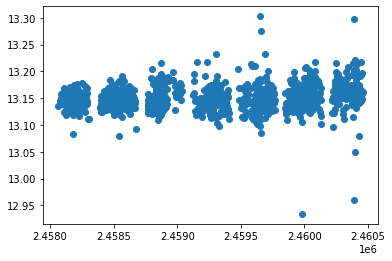

In [113]:
# plt.scatter(lc_0[lc_0['quality']=='G']['jd'], lc_0[lc_0['quality']=='G']['flux'])
plt.scatter(lc[lc['quality']=='G']['jd'], lc[lc['quality']=='G']['mag'])

# # pd.DataFrame(lc_0)
# mask = (lc_0['quality'].values=='G')
# # lc_0[mask]
# lc_0['jd'][mask]
# len(lc_0['jd'][mask]),len(lc_0)
lc

In [ ]:
def measure_prot(lc,max_period=100):
    lc = lc.remove_outliers().remove_nans()
    pg = lc.to_periodogram(maximum_period=max_period)
    pg.plot(view='period')
    
    period = pg.period_at_max_power
    print(period,period*2)
    lc_model = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
    
    # Plot the light curve
    ax = lc.plot()
    # Plot the model light curve on top
    lc_model.plot(ax=ax, lw=3, ls='--', c='red');

# 405924915
# 451423147
# 397526519

sr = lk.search_lightcurve('TIC 405924915', mission='TESS',author='TESS-SPOC')
lc = sr.download_all()
measure_prot(lc[0])
measure_prot(lc[1])



In [ ]:
ss

In [ ]:
def measure_prot(lc,max_period=100):
    lc = lc.remove_nans().remove_outliers().normalize()
    pg = lc.to_periodogram(maximum_period=max_period)
    pg.plot(view='period')
    
    period = pg.period_at_max_power
    print(period,period*2)
    lc_model = pg.model(time=lc.time, frequency=pg.frequency_at_max_power)
    
    # Plot the light curve
    ax = lc.plot()
    # Plot the model light curve on top
    lc_model.plot(ax=ax, lw=3, ls='--', c='red');

sr = lk.search_lightcurve('TIC 405924915', mission='TESS',author='QLP')
# sr = lk.search_lightcurve('TIC 405924915', mission='TESS',author='TESS-SPOC')
lc = sr.download_all()
print(sr)
measure_prot(lc[0])
measure_prot(lc[1])

# 112-23

In [ ]:
sr = lk.search_lightcurve('TIC 397526519', mission='TESS',author='TESS-SPOC')#,author='QLP')
lc = sr.download_all()

for l in lc:
    l.remove_nans().remove_outliers().plot()

In [ ]:
tpf_file = lk.search_targetpixelfile('TIC 397526519').download()

spoc_aperture_mask = tpf_file.pipeline_mask
tpf_file.plot(aperture_mask=spoc_aperture_mask)


In [ ]:
sr = lk.search_tesscut('TIC %s'%397526519)
print(sr)
for s in sr:
    s = s.download(cutout_size=15)
    s.plot()


In [ ]:

sr = lk.search_tesscut('TIC %s'%397526519)
print(len(sr)) 
# 2 is bad data
# 0 and 1 show smth
# 3 shows the periodic signal

tpf = sr[4].download(cutout_size=20)

tpf.interact_sky()


# 113-18

In [ ]:
# look at aperture spoc used

In [ ]:
sr = lk.search_lightcurve('TIC 451423147', mission='TESS',author='TESS-SPOC')#,author='QLP')
lc = sr.download_all()

for l in lc:
    l.remove_nans().remove_outliers().plot()

In [ ]:
sr = lk.search_tesscut('TIC %s'%451423147)
print(sr)
for s in sr:
    s = s.download(cutout_size=15)
    s.plot()


In [ ]:
sr = lk.search_tesscut('TIC %s'%451423147)

tpf = sr[1].download(cutout_size=15)

tpf.interact_sky()

In [ ]:
tpf_file = lk.search_targetpixelfile('TIC 451423147').download()

tpf_file
spoc_aperture_mask = tpf_file.pipeline_mask
tpf_file.plot(aperture_mask=spoc_aperture_mask)


# 113-16

In [ ]:
sr = lk.search_lightcurve('TIC 405924915', mission='TESS',author='QLP')
lc = sr.download_all()
for l in lc:
    l.plot()

In [ ]:
def check_tpf(tic):
    tpf = lk.search_targetpixelfile('TIC %s'%tic).download()
    for t in tpf:
        t.plot()
        print(t.sector)
    print(t.meta)

sr = lk.search_tesscut('TIC %s'%405924915)#.download_all(cutout_size=20)#, mission='TESS')

print(sr)
for s in sr:
    s = s.download(cutout_size=15)#, mission='TESS')
    s.plot()


In [ ]:
sr = lk.search_tesscut('TIC %s'%405924915)
print(len(sr))
tpf = sr[2].download(cutout_size=20)

tpf.interact()


In [ ]:
def paper_plot():
    from utils import PLOT_PARAMS
    PLOT_PARAMS(LS=10, SIZE=10)
    sr_113_16 = lk.search_lightcurve('TIC 405924915', mission='TESS',author='QLP')
    lc_113_16 = sr_113_16.download_all()
    
    sr_113_18 = lk.search_lightcurve('TIC 451423147', mission='TESS',author='TESS-SPOC')
    lc_113_18 = sr_113_18.download_all()
    
    sr_112_23 = lk.search_lightcurve('TIC 397526519', mission='TESS',author='TESS-SPOC')
    lc_112_23 = sr_112_23.download_all()
    
    fig, ((ax1, ax3, ax5 ), (ax2, ax4, ax6)) = plt.subplots(2,3 , figsize=(12,6))
    
    c='k'
    
    lc_113_16[0].remove_nans().remove_outliers().plot(ax=ax1,c=c)
    lc_113_16[1].remove_nans().remove_outliers().plot(ax=ax2,c=c)
    
    lc_113_18[0].remove_nans().remove_outliers().normalize().plot(ax=ax3,c=c)
    lc_113_18[1].remove_nans().remove_outliers().normalize().plot(ax=ax4,c=c)
    
    lc_112_23[0].remove_nans().remove_outliers().normalize().plot(ax=ax5,c=c)
    lc_112_23[1].remove_nans().remove_outliers().normalize().plot(ax=ax6,c=c)
    
    ax1.set_title('P113 - RG 16', fontsize=13)
    ax3.set_title('P113 - RG 18', fontsize=13)
    ax5.set_title('P112 - RG 23', fontsize=13)
    
    for ax in [ax1, ax3, ax5, ax2, ax4, ax6]:
        ax.legend(loc='upper left',fontsize=12)
        ax.grid(color='grey',ls='dotted',zorder=-100)
    
    for ax in [ax3, ax5, ax4, ax6]:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)
    #plt.savefig('../plots/lightcurves_%s.png'%DATE,bbox_inches='tight',dpi=150)
    print(len(sr_113_16),len(sr_113_18),len(sr_112_23))
    
paper_plot()

In [ ]:
ss

In [ ]:
sr = lk.search_tesscut('TIC %s'%405924915)

tpf = sr[1].download(cutout_size=15)

tpf.interact_sky()

In [ ]:
tpf_file = lk.search_targetpixelfile('TIC %s'%405924915).download()

spoc_aperture_mask = tpf_file.pipeline_mask
# tpf_file.plot(aperture_mask=spoc_aperture_mask)
spoc_aperture_mask

In [ ]:
ss

In [ ]:
merged[merged.TIC==405924915][['TIC','sobject_id','P50','program','RG_id','Mj50']]



In [ ]:
merged[(merged.program==112) & (merged.RG_id==23)][['TIC','sobject_id','P50','program','RG_id','Mj50']]


In [ ]:
merged[(merged.program==113) & (merged.RG_id==18)][['TIC','sobject_id','P50','program','RG_id','Mj50']]

In [ ]:
ss

In [ ]:
for i,tic in enumerate([34732287, 38023437, 129040309,397526519, 
            306791669, 167669457, 83864042, 369985256, 205846638, 
            78326923, 405924915, 451423147, 361334013, 412764815, 165063707]):
    if i<14: continue
    print(i)
    sr = lk.search_tesscut('TIC %s'%tic)#.download_all(cutout_size=20)#, mission='TESS')
    tpfs = sr.download_all(cutout_size=15)
    tpfs.plot()
    plt.savefig('tess_tpf/%s.png'%tic,bbox_inches='tight',dpi=150)
# for s in sr:
#     s = s.download(cutout_size=15)#, mission='TESS')
#     s.plot()


In [ ]:
def check_tpf(tic):
    tpf = lk.search_targetpixelfile('TIC %s'%tic).download()
    for t in tpf:
        t.plot()
        print(t.sector)
    print(t.meta)
#     sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='QLP')
#     print(sr)

    return 0
#     return tpf 
# tpf = check_tpf(397526519)
sr = lk.search_tesscut('TIC %s'%397526519)#.download_all(cutout_size=20)#, mission='TESS')
for s in sr:
    s = s.download(cutout_size=15)#, mission='TESS')
    s.plot()

# tpf = lk.search_targetpixelfile('TIC %s'%397526519, sector=65).download()
# tpf.interact()


In [ ]:
sr = lk.search_lightcurve('TIC 397526519', mission='TESS',author='QLP')
lc = sr.download_all()

print(len(lc))
measure_prot(lc[2])
measure_prot(lc[3])
sr

In [ ]:
sr = lk.search_lightcurve('TIC 34732287', mission='TESS',author='QLP')
lc = sr.download_all()
print(len(lc))
for l in lc:
    measure_prot(l)
# measure_prot(lc[2])
# measure_prot(lc[3])



# Check the two planetary companions

In [ ]:
plt.scatter(table4.Mj50, table4.Li_val)
plt.xscale('log')

mask = (table4.Mj50<12)
plt.scatter(table4[mask].Mj50, table4[mask].Li_val)

table4[['sobject_id','ra_dr2','dec_dr2']].to_csv('all_table4.csv',index=False)

In [ ]:
tess_ids = {
    1: {'GAIA': 4134444748741183488, 
     'TESS': 78326923,
     'GALAH': 170509005201208},
    2: {'GAIA': 2622883652325300992, 
     'TESS': 205846638,
     'GALAH': 140707003101315},}


In [ ]:
crossmatch_tess_all = pd.read_csv('../files/crossmatch_tess_all_binaries.csv')#[['GAIA','TIC','WISEA','2MASS','ra_dr2','dec_dr2','RAJ2000','DEJ2000']]


In [ ]:
merged = pd.merge(crossmatch_tess_all, table4, on='sobject_id')#[crossmatch_tess_all.program==113]
merged[merged.TIC==451423147][['TIC','sobject_id','P50','program','RG_id']]
merged[(merged.program==113) & (merged.RG_id==19)][['TIC','sobject_id','P50','program','RG_id']]
merged[merged.sobject_id==170416004301008][['TIC','sobject_id','P50','program','RG_id','Li_val']]

In [ ]:

merged[merged['TIC']==397526519][['TIC','sobject_id','P50','program','RG_id','Li_val']]


In [ ]:

# done: 397526519,369985256,405924915,361334013,451423147
from utils import PLOT_PARAMS
PLOT_PARAMS()
def make_paper_plot(tic):
    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='QLP')
    lcs = sr.download_all()
    if len(lcs) == 4:
        fig = plt.figure(figsize=(5,10))
    elif len(lcs) == 2:
        fig = plt.figure(figsize=(5,5))
    elif len(lcs) == 3:
        fig = plt.figure(figsize=(6,6))
        
    
    for i,lc in enumerate(lcs):
        ax = plt.subplot(len(lcs),1,i+1)
        lc = lc.remove_outliers()
        time, flux = lc.time.value, lc.flux.value
        pg = lc.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
        ax.plot(time, flux, lw=0.5, color='k')
#         lc.remove_outliers().plot(ax=ax)
    
    fig.text(0.5, 0.0, 'Time [days]', ha='center')
    fig.text(-0.03, 0.5, 'Normalized Flux', va='center', rotation='vertical')
    
    plt.tight_layout()
#     plt.savefig('../plots/tess_prot_%s.png'%tic,bbox_inches='tight',dpi=200)
    print(sr.author)
# make_paper_plot()


In [ ]:
sr1 = lk.search_lightcurve('TIC 78326923', mission='TESS')

In [ ]:
crossmatch_tess_planets = pd.read_csv('../files/crossmatch_tess.csv')

In [ ]:
crossmatch_tess_planets[['GAIA','TIC','WISEA','2MASS','ra_dr2','dec_dr2','RAJ2000','DEJ2000']]

In [ ]:

sr1 = lk.search_lightcurve('TIC 78326923', mission='TESS')
lc1 = sr1.download()
lc1.plot()
lc1 = lc1.remove_nans().remove_outliers() 
lc1.plot()

In [ ]:
sr2 = lk.search_lightcurve('TIC 205846638', mission='TESS')
lc2 = sr2.download_all()
lc2[0].plot()
lc2a = lc2[0].remove_nans().remove_outliers()
lc2a.plot()

lc2[1].plot()
lc2b = lc2[1].remove_nans().remove_outliers()
lc2b.plot()

In [ ]:
print('cadence in days:',np.median(np.diff(lc1['time'].value)))
print('cadence in mins:',np.median(np.diff(lc1['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc1['time'].value))*86400.)

In [ ]:
sr2
print('cadence in days:',np.median(np.diff(lc2[0]['time'].value)))
print('cadence in mins:',np.median(np.diff(lc2[0]['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc2[0]['time'].value))*86400.)
print('\n')
print('cadence in days:',np.median(np.diff(lc2[1]['time'].value)))
print('cadence in mins:',np.median(np.diff(lc2[1]['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc2[1]['time'].value))*86400.)

In [ ]:
pg1 = lc1.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg1.plot()

In [ ]:

pg2 = lc2a.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg2.plot()
pg2 = lc2b.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg2.plot()

# Download lightcurves from TESS for all targets:

In [ ]:
si = crossmatch_tess_all[crossmatch_tess_all.TIC==167669457]['sobject_id'].values[0]
print(si)
print(table4[table4.sobject_id==si].Mj50.values[0])
print(table4[table4.sobject_id==si].P50.values[0])
print(table4[table4.sobject_id==si].radius_bstep.values[0])

In [ ]:
def remove_prot(lc, ax=False, width=1.):
    time = lc.time.value
    cadence_days = np.median(np.diff(time))#days
    cadence_mins = cadence_days*86400./60.
    cadence_secs = cadence_days*86400.
#     print('Cadence in Days: %.1f \t Mins: %.2f \t Secs: %.3f'%(cadence_days,cadence_mins,cadence_secs))
    boxsize=int(width/cadence_days)-1 #width in days
    lc_flat=lc.flatten(window_length=boxsize)
    if ax:
        lc_flat.plot(ax=ax)
    return lc_flat

def remove_outliers(lc_flat, ax=False, N=5.):
    # Remove data points > N*sigma:
    std =mad_std(lc_flat.flux,ignore_nan=True)
    med =np.nanmedian(lc_flat.flux)
    idx =np.where(abs(lc_flat.flux-med)<=(N*std))[0]
    time=lc_flat.time[idx].value
    flux=lc_flat.flux[idx].value
    lc = lk.LightCurve(time, flux)
    if ax:
        lc.plot(ax=ax)
    return lc
   
def calc_periodogram(lc, ax):
    pg_flat=lc.to_periodogram(method='lombscargle',normalization='psd')#,oversample_factor=1)
    pg_flat.plot(ax=ax,scale='log')

In [ ]:

# freq, amp = LombScargle(time, flux).autopower(method = 'fast',samples_per_peak=1, maximum_frequency=nyq_cd)
# freq = 1e6*freq/(86400.)  # convert frequency to muHz
# res  = freq[1]-freq[0]
# psd  = 2.*amp*np.var(flux*1e6)/(np.sum(amp)*res)

# cadence = np.nanmedian(np.diff(time))       # cadence in days (=60 s)
# cadence = int(cadence*60.*60.*24.)   # cadence in secs
# nyq     = 1./(2.*cadence)       # Nyq. frequency in Hz
# nyq_cd  = nyq*86400.            # Nyq. frequency in cycles/day
# #print('Cadence [s]',round(cadence,2),'Nyquist [Hz]',round(nyq,9),'Nyquist [c/d]',round(nyq_cd,2))


In [ ]:
def remove_gaps(all_time, all_flux):
    #ax1.plot(all_time, all_flux,lw=0.1)
    
    df = pd.DataFrame({'time': all_time, 'flux': all_flux})
    df['delta']  = df['time'].diff()              # diff from previous time
    df['gap']    = df['delta']>=2.                # gap = diff > 2 days
    df['group']  = df['gap'].cumsum()             # make groups
    
    groups = df.groupby('group')
    
    min_time = np.zeros(len(groups))
    max_time = np.zeros(len(groups))
    
    for i, g in groups:
        min_time[i]=min(g['time'])
        max_time[i]=max(g['time'])
    
    new_times = {}
    new_flux  = {}
    total_dt = 0
    for i, g in groups:
        if i > 0:
            dt  = min_time[i] - max_time[i-1]
            total_dt+=dt
            new_times[i] = g['time']-(total_dt)
            
        else:
            new_times[i] = g['time']
        new_flux[i] = g['flux']

    all_time, all_flux = [], []
    for i in range(len(groups)):
        all_time.append(list(new_times[i]))
        all_flux.append(list(new_flux[i]))

    from itertools import chain
    all_time = list(chain.from_iterable(all_time))
    all_flux = list(chain.from_iterable(all_flux))

    all_time, all_flux = np.array(all_time), np.array(all_flux)
    return all_time, all_flux
    
    

In [ ]:
# sr = lk.search_lightcurve('TIC %s'%38023437, mission='TESS')
# lcs = sr.download_all()
# ax1=plt.subplot(211)
# ax2=plt.subplot(212)
# for lc in lcs: 
#     t1,f1 = lc.time.value, lc.flux.value
#     t2,f2 = lc.time.value, f1*1e-6+1
#     ax1.plot(t1,f1,lw=1)
#     ax2.plot(t2,f2,lw=1)
# plt.tight_layout()
# plt.show()
    
# # lc.meta

In [ ]:

# data = np.random.random(100)
# bins = np.linspace(0, 1, 10)
# dig = np.digitize(data, bins)
# bin_means = [data[dig == i].mean() for i in range(1, len(bins))]

# plt.plot(data)
# plt.plot(bin_means)


In [ ]:
lk.search_lightcurve('TIC %s'%397526519, mission='TESS')

sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS') 

# lcs = sr.download_all()
new_sr = []
d = {}
for i in sr:
    print(i.author,i.mission)# (i.mission).split(' '))
    if i.mission[0] not in d.keys():
        d[i.mission[0]]=[i.author[0]]
    else:
        d[i.mission[0]].append(i.author[0])
        


In [ ]:
d
ts_65 = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='TESS-SPOC',sector=65) 
ts_64 = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',sector=64) 

In [ ]:
ts_64
lcs = []
for k,v in d.items():
    sector = k.split(' ')[-1]
    if len(v) == 1:
        sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author=v[0],sector=sector) 
        lc = sr.download()
    else:
        if 'TESS-SPOC' in v:
            print(v)
            sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='TESS-SPOC',sector=sector) 
            lc = sr.download()
            print(v)
        elif 'QLP' in v:
            sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='QLP',sector=sector)
            lc = sr.download()
    lcs.append(lc)


In [ ]:
# lc.exptime
(lc.time[1]-lc.time[0])*86400

In [ ]:
# for lc in lcs:

for lc in lk.LightCurveCollection(lcs) :
    
    if lc.author == 'TESS-SPOC':
        print('ts',(lc.time[1]-lc.time[0])*86400)
        lc.remove_nans().remove_outliers().plot(normalize=True)
    else:
        print((lc.time[1]-lc.time[0])*86400)

In [ ]:
star=165063707
sr = lk.search_lightcurve('TIC %s'%star, mission='TESS') 
sr


In [ ]:
lk.search_lightcurve('TIC %s'%star, mission='TESS', author='QLP').download_all().plot()


In [ ]:
lk.search_lightcurve('TIC %s'%star, mission='TESS', author='TESS-SPOC').download_all().plot()


In [ ]:
for i,star in enumerate([34732287, 38023437, 129040309,#397526519,
             306791669, 167669457, 83864042, 369985256, 205846638, 
             78326923, 405924915, 451423147, 361334013, 412764815, 165063707]):
    sr = lk.search_lightcurve('TIC %s'%star, mission='TESS')
    if i != 0: continue
    print(sr.mission)

In [ ]:
sectors = {129040309: [0,1],306791669:[0,1]}

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
def do_seismology(tic,priority=False,sectors=False):
    if priority:
        sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author=priority)
        lcs = sr.download_all()
        if sectors:
            lcs=lcs[sectors]
    else:
        # 1st: save all sectors and authors for each:
        sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
        
        d = {}
        for i in sr:
            if i.mission[0] not in d.keys():
                d[i.mission[0]]=[i.author[0]]
            else:
                d[i.mission[0]].append(i.author[0])

        # 2nd: prioritize TESS-SPOC first, then QLP:
        lcs = []
        for k,v in d.items():
            sector = k.split(' ')[-1]
            if len(v) == 1:
                sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author=v[0],sector=sector) 
                lc = sr.download()
            else:
                if 'TESS-SPOC' in v:
                    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='TESS-SPOC',sector=sector) 
                    lc = sr.download()
                elif 'QLP' in v:
                    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='QLP',sector=sector)
                    lc = sr.download()
            lcs.append(lc)

        lcs = lk.LightCurveCollection(lcs) 
        print(len(lcs))
    
    rows, cols = int(len(sr) / 2), 2
    figsize=(12,4)
    all_time, all_flux = [],[]
    
    time_before_bin, flux_before_bin = [],[]
    
    stds = np.zeros(len(lcs))
    for ii, lc in enumerate(lcs):
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,12))
        lc.plot(ax=ax1,label='unbinned')
        #time, flux = lc.time.value, lc.flux.value
#         if max(flux) > 2.:
#             print(ii, 'here')
#             flux = flux*1e-6+1
        
        # remove rotation
        lc_flat = remove_prot(lc,ax2)
        
        # remove outliers
        lc_flat = remove_outliers(lc_flat,ax3)        
        
        time_before_bin.append(lc_flat.time.value)
        flux_before_bin.append(lc_flat.flux.value)
        
        # binning
        time = lc_flat.time.value
        flux = lc_flat.flux.value
        
        exp_cadence_days = 30./(60.*24.) # 30 min cadence
        obs_cadence_days = np.median(np.diff(time))
        
        if abs(round(obs_cadence_days*86400)-1800)<=1.:
            print('here',len(lc_flat))
            binned_lc = lc_flat*1
        else:
            Nth  = round(exp_cadence_days/obs_cadence_days)
            binned_time, binned_flux = time.copy(), flux.copy()
            binned_time, binned_flux = binned_time[1::Nth], binned_flux[1::Nth]
            binned_lc     = lk.LightCurve(time=binned_time, flux=binned_flux)

        # save binned lightcurve
        all_time.append(binned_lc.time.value)
        all_flux.append(binned_lc.flux.value)
        stds[ii] = np.nanstd(binned_lc.flux.value)
        
        # plot binned lightcurve
        binned_lc.plot(ax=ax3,label='binned')  
        ax3.legend()
        plt.tight_layout()
        plt.close()
        
        
    
#     plt.figure(figsize=(8,4))
#     for i in range(len(all_time)):
#         plt.plot(all_time[i],all_flux[i])
#     plt.show()
    print('std',stds)
#     mask = np.where(stds<=1.25*(np.median(stds)))[0]
    
#     t, f = [], []
#     for i in range(len(all_time)):
#         if i in mask:
#             t.append(all_time[i])
#             f.append(all_flux[i])
    
#     all_time, all_flux = t*1, f*1
#     plt.figure(figsize=(8,4))
#     for i in range(len(all_time)):
#         plt.plot(all_time[i],all_flux[i],label=i,alpha=0.5)
#     plt.legend()
#     plt.show()
    
    # removing gaps routine (binned data)
    all_time = np.array([i for sublist in all_time for i in sublist])
    all_flux = np.array([i for sublist in all_flux for i in sublist])
    
    sorted_i = np.argsort(all_time)
    all_time = all_time[sorted_i]
    all_flux = all_flux[sorted_i]
    
    new_time, new_flux = remove_gaps(all_time, all_flux)
    
    # removing gaps routine (not-binned data)
    time_before_bin =  np.array([i for sublist in time_before_bin for i in sublist])
    flux_before_bin =  np.array([i for sublist in flux_before_bin for i in sublist])
    sorted_i = np.argsort(time_before_bin)
    time_before_bin, flux_before_bin = time_before_bin[sorted_i], flux_before_bin[sorted_i]
    time_before_bin, flux_before_bin = remove_gaps(time_before_bin, flux_before_bin)
#     all_time_og, all_flux_og = np.copy(all_time),np.copy(all_flux),
        
    

#     plt.figure(figsize=(8,4))
#     plt.plot(new_time, new_flux)
#     plt.legend()
#     plt.show()
    
    cadence_30min = int(30*60.)     # 30 mins cadence in secs
    nyq     = 1./(2.*cadence_30min) # Nyq. frequency in Hz
    nyq_cd  = nyq*86400.            # Nyq. frequency in cycles/day

    def manual_periodogram(time, flux):
        freq, amp = LombScargle(time, flux).autopower(method = 'fast', maximum_frequency=nyq_cd)#,samples_per_peak=1)
        freq = 1e6*freq/(86400.)  # convert frequency to muHz
        res  = freq[1]-freq[0]
        psd  = 2.*amp*np.var(flux*1e6)/(np.sum(amp)*res)
        return freq, psd

    fig, (ax1a,ax1b,ax2,ax3) = plt.subplots(4,1,figsize=(8,10))
    
    ax1a.plot(all_time, all_flux, lw=1,label='data for all sectors\n(outliers/period removed)')
    ax1a.set_title('gaps not removed',fontsize=10)
    
    ax1b.set_title('gaps removed',fontsize=10)
    ax1b.plot(time_before_bin, flux_before_bin, lw=1,label='before binning', alpha=0.5)
    ax1b.plot(new_time, new_flux, lw=1,label='after binning', alpha=0.5)
    
#     ax1b.plot(new_time, new_flux, lw=1,label='removing outliers & prot again')
    
    lc1 = lk.LightCurve(time=all_time, flux=all_flux)
    lc2 = lk.LightCurve(time=new_time, flux=new_flux)
    
    lc1 = remove_outliers(lc1,N=3)
    lc2 = remove_outliers(lc2,N=3)
    all_time , all_flux = lc1.time.value, lc1.flux.value
    new_time , new_flux = lc2.time.value, lc2.flux.value

    #ax1b.plot(new_time, new_flux, label='manual removal')
    
    freq, psd         = manual_periodogram(all_time, all_flux)
    new_freq, new_psd = manual_periodogram(new_time, new_flux) 

    fres_cd     = 30./(24.*60.)  #to check if it's smoothed by 2muHz: print(freq[0],freq[0+n]) difference should be 2
    smooth_freq = 0.5
    
    fres_mhz    = fres_cd/0.0864
    n  = int(smooth_freq/fres_mhz)
    gauss_kernel = Gaussian1DKernel(n)
    new_pssm   = convolve(new_psd, gauss_kernel)

    ax2.loglog(freq, psd,lw=1,label='gaps not removed')
    ax2.loglog(new_freq, new_psd,lw=1,label='gaps removed')
    
    #ax2.loglog(new_freq, new_pssm,lw=1,c='k',label='smoothed')
    ax2.set_xlim(1,280)
    
    ax3.plot(freq, psd,lw=1,label='gaps not removed')
    ax3.plot(new_freq, new_psd,lw=1,label='gaps removed')
    ax3.set_xlim(1,100)
    
    for ax in [ax1a,ax1b,ax2,ax3]: ax.legend()
    
    mask = (new_freq>20.)
    new_freq, new_psd = new_freq[mask], new_psd[mask]
    lc_data = np.array([new_time, new_flux]).T
    ps_data = np.array([new_freq, new_psd]).T

    np.savetxt('%s_LC.txt'%tic, lc_data)
    np.savetxt('%s_PS.txt'%tic, ps_data)
#     ax1b.set_xlim(1625,1652)
#     ax1b.set_ylim(0.998,1.002)
    plt.tight_layout()
    plt.savefig('%s_tess_5.png'%tic,bbox_inches='tight',dpi=200)
#     plt.close()
    
# do_seismology(397526519,priority='TESS-SPOC')

# messaged dan about this 'issue':
# do_seismology(34732287,priority='QLP')  # remove last sector?
# do_seismology(38023437,priority='QLP')  # remove last sector?
# do_seismology(167669457,priority='QLP') # same problem as message to Dan
# do_seismology(361334013,priority='QLP') # same problem as message to Dan

# do_seismology(405924915,priority='QLP')
# do_seismology(451423147,priority='TESS-SPOC')

do_seismology(412764815,priority='QLP')
do_seismology(165063707,priority='QLP')

# do_seismology(129040309,priority='QLP',sectors=sectors[129040309]) 
# do_seismology(306791669,priority='QLP',sectors=sectors[306791669]) 


# 427449567 - removed YSO
# for i,star in enumerate([34732287, 38023437, 129040309,#397526519,
#              306791669, 167669457, 83864042, 369985256, 205846638, 
#              78326923, 405924915, 451423147, 361334013, 412764815, 165063707]):
#     print(i,star)
#     try:
#         do_seismology(star)
#     except Exception as e:
#         print(e)

In [ ]:
# pysyd run --star 129040309 --numax 50  --lp 47 --up 58  --sp 0.02 --lb 20
# pysyd run --star 397526519 --numax 50 --lp 42 --up 60 --sp 0.05 --lb 30
# pysyd run --star 306791669 --numax 50  --lp 40 --up 60 --sp 0.05 --lb 20


In [ ]:


#     if tic == 34732287 : 
#         m1 = (all_time >= 1488.)
#         m2 = (new_time >= 1488.)
# #     elif tic == 397526519: 
# #         m1 = (all_time <= 1620.),
# #         m2 = (new_time <= 1620.),
#     elif tic == 38023437: 
#         m1 = (all_time <= 1488.),
#         m2 = (new_time <= 1488.),
#     elif tic == 129040309 : 
#         m1 = (all_time<=1682),
#         m2 = (new_time<=1682),
#     elif tic == 306791669 : 
#         m1 = (all_time>=1642),
#         m2 = (new_time>=1642),
#     elif tic == 167669457 : 
#         m1 = ((all_time>=1600)  & (all_time<=1610)) | (all_time>=1615),
#         m2 = ((new_time>=1600)  & (new_time<=1610)) | (new_time>=1615),
#     elif tic == 83864042: 
#         m1 = (all_time<=1622),
#         m2 = (new_time<=1622),
#     elif tic == 78326923: 
#         m1 = (all_time<=3782) | (all_time>=3786 & (all_time<=3797)),
#         m2 = (new_time<=3782) | (new_time>=3786 & (new_time<=3797)),
#     elif tic == 405924915: 
#         m1 = (all_time>=1657),
#         m2 = (new_time>=1657),
#     elif tic == 451423147: 
#         m1 = (all_time<=2390.),
#         m2 = (new_time<=2390.),
#     elif tic == 361334013: 
#         m1 = (all_time>=1652) & (all_time<=1680)
#         m2 = (new_time>=1652) & (new_time<=1680)
#     else:
#         m1 = (all_time > 0)
#         m2 = (new_time > 0)
        
#     new_time, new_flux = new_time[m2], new_flux[m2]

In [ ]:
ss

In [ ]:
def make_ind_plots(tics): 
    for i,tic in enumerate(np.sort(tics)):
        try:
            sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
            print(len(sr))
            if len(sr) == 1:
                lc = sr.download_all()
                plt.figure(figsize=(8,4))
                ax = plt.subplot(1,1,1)
                lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
                rows, cols = 1, 1
            elif len(sr)%2 == 0:#even
                rows, cols = int(len(sr) / 2), 2
                
                lcs = sr.download_all()
                if len(sr) ==2:
                    figsize=(12,4)
                elif len(sr) ==4:
                    figsize=(12,8)
                elif len(sr) > 4:
                    figsize=(12,14)
                
                fig = plt.figure(figsize=figsize)
                for ii, lc in enumerate(lcs):
                    ax=plt.subplot(rows,cols,ii+1)
                    lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
                
            elif len(sr)%2 == 1:#odd
                rows, cols = int((len(sr)+1)/2), 2
                
                lcs = sr.download_all()
                if len(sr) == 3:
                    figsize=(12,8)
                elif len(sr) > 4:
                    figsize=(12,14)
                
                fig = plt.figure(figsize=figsize)
                for ii, lc in enumerate(lcs):
                    ax=plt.subplot(rows,cols,ii+1)
                    lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
        except Exception as e:
            print(e)
make_ind_plots(crossmatch_tess_all.TIC)

In [ ]:
print(crossmatch_tess_all.TIC.tolist())

In [ ]:
def download_data(tic=False):
    if tic:
        try:
            sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
            lc = sr.download_all()
            lc.plot()

    #         lc[2].plot(ax=ax,normalize=True)
    #         #ax.set_xlim(2339, 2341)
    #         plt.show()
            print(len(sr))
            for l in lc:
                l = l.remove_nans()#.remove_outliers() 
                l.plot()
        except Exception as e:
            print(e)
            
    else:
        for i, row in all_tics.iterrows():
            tic = row['TIC']
            print(i,tic)
            try:
                sr1 = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
                print(len(sr1))
                lc1 = sr1.download_all()
                lc1.plot()
            except Exception as e:
                print(e)

    #         lc1.plot()
    #         



In [ ]:
download_data()

In [ ]:
def dd2(tic):
    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
    lc = sr.download_all()
    #lc[1].plot()
    plt.figure(dpi=200)
    ax=plt.subplot(111)
    lc[1].plot(ax=ax,normalize=True)
    ax.set_xlim(2335,2340)
    ax.set_ylim(0.95,1.05)
    ax.axhline(1.02)
    ax.axhline(1.0)
dd2(167669457)